# 자전거 대여 데이터

- 2011년부터 2022년까지 2년간의 자전거 대여 데이터 
- 캐피털 바이크셰어 회사가 공개한 운행 기록에 다양한 외부 소스에서 얻은 당시 날씨 정보를 조합 
- 한 시간 간격으로 기록됨
- 훈련 데이터 : 매달 1일부터 19일까지의 기록
- 테스트 데이터 : 매달 20일부터 월말까지의 기록 
- 피처
    - datetime : 기록 일시(1시간 간격)
    - season : 계절 
        - 1 : 봄(1분기)
        - 2 : 여름(2분기)
        - 3: 가을(3분기)
        - 4 : 겨울(4분기) 
        - 공식 문서에는 계절로 설명하고 있지만 실제로는 분기로 나누어져 있음 
    - holiday : 공휴일 여부(0 : 공휴일 아님, 1 : 공휴일)
    - workingday : 근무일 여부(0 : 근무일 아님, 1 : 근무일)
        - 주말과 공휴일이 아니면 근무일이라고 간주 
    - weather : 날씨
        - 1 : 맑음
        - 2 : 옅은 안개, 약간 흐림
        - 3 : 약간의 눈, 약간의 비와 천둥 번개, 흐림  
        - 4 : 폭우와 천둥 번개, 눈과 짙은 안개 
    - temp : 실제 온도
    - atemp : 체감 온도
    - humidity : 상대 습도
    - windspeed : 풍속
    - casual : 등록되지 않은 사용자(비회원) 수
    - registered : 등록된 사용자(회원) 수
    - count : 자전거 대여 수량 
- 종속변수 : count 
- 평가지표 : RMSLE(Root Mean Squared Logarithmic Error) 

1. test, train 컬럼이 조금 다름 
2. test, submisson 의 datetime 이 같음 
3. train 1/21 날짜가 없다 ( test 데이터에 만 있음)
4. test 데이터에 정답값이 없다.
5. test 데이터 예측해서 submission 파일처럼 datetime/ count 컬럼으로 csv 파일로 만들어서 쌤께 제출 

In [93]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


# 머신러닝 import 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_log_error

from datetime import datetime

In [181]:
sample_df = pd.read_csv('./data/bike/sampleSubmission.csv')
sample_df.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [182]:
test_df = pd.read_csv('./data/bike/test.csv')
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [183]:
train_df = pd.read_csv('./data/bike/train.csv')
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [184]:
train_df.shape, test_df.shape

((10886, 12), (6493, 9))

- train 데이터에 10886의 데이터, test 데이터에는 6493개가 있으며, 두 데이터는 컬럼 수가일치 하지않는다

In [185]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [186]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


- 2개의 데이터 모두 datetime 컬럼을 제외한 모든 컬럼이 수치형 데이터이다. 

In [187]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [188]:
test_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


### 두 데이터의 상관관계

In [189]:
train_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [190]:
train_1 = train_df.drop(['season', 'holiday', 'workingday','casual','registered'], axis =1 )
train_1.head()

,datetime,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,9.84,14.395,75,0.0,1


In [191]:
train_1_corr = train_1.corr(numeric_only=True)
train_1_corr

,weather,temp,atemp,humidity,windspeed,count
weather,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


### 상관관계 시각화

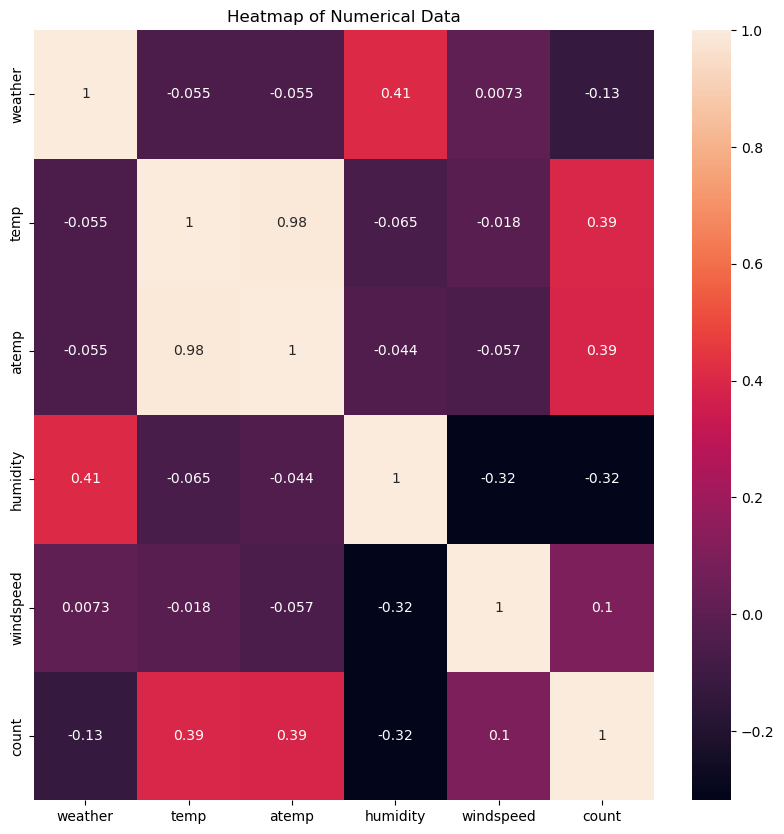

In [192]:
corrMat = train_1_corr
fig, ax= plt.subplots() 
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True) # 상관관계 히트맵 그리기
ax.set(title='Heatmap of Numerical Data');

- windspeed는 종속변수 count와 관련이 낮아 제거해도 될 컬럼같아 보인다 

In [193]:
train_df.corr(numeric_only=True)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


#### Casual & Registered 제외한 상관관계

In [194]:
train_1.corr(numeric_only=True)

,weather,temp,atemp,humidity,windspeed,count
weather,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


In [195]:
test_df.corr(numeric_only=True)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
season,1.000000,-0.075759,0.051488,-0.053554,0.401384,0.410626,0.083792,-0.154507
holiday,-0.075759,1.000000,-0.255820,-0.033279,-0.071852,-0.072373,-0.031611,-0.003240
workingday,0.051488,-0.255820,1.000000,0.062447,0.096519,0.103202,0.059599,-0.053690
weather,-0.053554,-0.033279,0.062447,1.000000,-0.179034,-0.185746,0.437406,0.057360
temp,0.401384,-0.071852,0.096519,-0.179034,1.000000,0.991936,-0.081734,-0.030990
atemp,0.410626,-0.072373,0.103202,-0.185746,0.991936,1.000000,-0.068666,-0.069655
humidity,0.083792,-0.031611,0.059599,0.437406,-0.081734,-0.068666,1.000000,-0.242708
windspeed,-0.154507,-0.003240,-0.053690,0.057360,-0.030990,-0.069655,-0.242708,1.000000


- count 는 registered 와 casual 합이기 때문에 수치가 높게 나와서 감안하고 보면 좋을것같다 
- temp	atemp	humidity 이 3개의 컬럼이 제일 관련성이 높을 독립변수 인듯 하다

In [196]:
def rmsle(y_true, y_pred, convertExp = True):
    '''
    실제 타깃값과 예측값을 인수로 전달하면 RMSLE 수치를 반환하는 함수
    convertExp : 입력 데이터를 지수변환할지 정하는 파라미터
    타깃값으로 log(count)를 사용한 경우에는 지수변환을 해줘야 함
    '''
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))

    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))

    return output

# 머신러닝용 전처리 

In [197]:
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [198]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### 베이스 라인 

In [199]:
# train 데이터에서 weather 이상치 4 제거하기 
train_df = train_df[train_df['weather'] != 4]
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [200]:
all_data_temp = pd.concat([train_df, test_df])
all_data_temp

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [201]:
all_data = pd.concat([train_df, test_df], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


## 날짜의 대한 독립변수들 추가 

In [202]:
# 자전거 1시간에 한번씩 대여하니까 날짜 컬럼을 분리를 해야될것같다 

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 요일 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())

In [203]:
all_data.isna().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
date             0
year             0
month            0
hour             0
weekday          0
dtype: int64

In [204]:
all_data['date'][100]

'2011-01-05'

In [205]:
# import calendar

# print(all_data['date'][100]) # 날짜
# print(datetime.strptime(all_data['date'][100], '%Y-%m-%d')) # datetime 타입으로 변경
# print(datetime.strptime(all_data['date'][100], '%Y-%m-%d').weekday()) # 정수로 요일 반환
# print(calendar.day_name[datetime.strptime(all_data['date'][100], '%Y-%m-%d').weekday()]) # 문자열로 요일 반환

In [206]:
# all_data['weekday'] = all_data['date'].apply(
#     lambda dateString: 
#     calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])

In [207]:
all_data.head(80)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,2011-01-01,2011,01,00,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,2011-01-01,2011,01,01,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,2011-01-01,2011,01,02,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,2011-01-01,2011,01,03,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,2011-01-01,2011,01,04,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2011-01-04 07:00:00,1,0,1,1,4.92,7.575,74,8.9981,2.0,92.0,94.0,2011-01-04,2011,01,07,1
76,2011-01-04 08:00:00,1,0,1,1,5.74,7.575,69,11.0014,2.0,177.0,179.0,2011-01-04,2011,01,08,1
77,2011-01-04 09:00:00,1,0,1,1,6.56,7.575,64,15.0013,2.0,98.0,100.0,2011-01-04,2011,01,09,1
78,2011-01-04 10:00:00,1,0,1,2,6.56,6.820,69,22.0028,5.0,37.0,42.0,2011-01-04,2011,01,10,1


In [208]:
remove_features = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']
all_data= all_data.drop(remove_features, axis = 1)

In [209]:
all_data[pd.isnull(all_data['count'])]

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
10885,1,0,1,1,10.66,11.365,56,NaN,2011,00,3
10886,1,0,1,1,10.66,13.635,56,NaN,2011,01,3
10887,1,0,1,1,10.66,13.635,56,NaN,2011,02,3
10888,1,0,1,1,10.66,12.880,56,NaN,2011,03,3
10889,1,0,1,1,10.66,12.880,56,NaN,2011,04,3
...,...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,NaN,2012,19,0
17374,1,0,1,2,10.66,12.880,60,NaN,2012,20,0
17375,1,0,1,1,10.66,12.880,60,NaN,2012,21,0
17376,1,0,1,1,10.66,13.635,56,NaN,2012,22,0


In [216]:
all_data['weekday'].value_counts()

weekday
5    2512
6    2502
4    2487
0    2478
2    2475
3    2471
1    2453
Name: count, dtype: int64

## 머신러닝용 전처리

In [210]:
# 훈련 데이터와 테스트 데이터 나누기

x_train = all_data[pd.isnull(all_data['count'])]
x_test = all_data[pd.isnull(all_data['count'])]

In [211]:
x_train.shape,x_test.shape

((6493, 11), (6493, 11))

In [212]:
# 종속변수 count 제거 
x_train = x_train.drop('count', axis = 1)
x_test = x_test.drop('count', axis = 1)
y = train_df['count'] 

In [213]:
x_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
10885,1,0,1,1,10.66,11.365,56,2011,00,3
10886,1,0,1,1,10.66,13.635,56,2011,01,3
10887,1,0,1,1,10.66,13.635,56,2011,02,3
10888,1,0,1,1,10.66,12.880,56,2011,03,3
10889,1,0,1,1,10.66,12.880,56,2011,04,3


## 모델 훈련

In [214]:
linear_reg_model = LinearRegression()

log_y = np.log(y)  # 타깃값 로그변환
linear_reg_model.fit(x_train, log_y) # 모델 훈련

ValueError: Found input variables with inconsistent numbers of samples: [6493, 10885]